# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [4]:
data = pd.read_csv('data/cost_revenue_dirty.csv')

# Explore and Clean the Data


1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [5]:
data.shape

(5391, 6)

In [23]:
print(f'Any NaN values among the data: {data.isna().values.any()}')

Any NaN values among the data: False


In [24]:
print(f'Any duplicates: {data.duplicated().values.any()}')
duplicates_rows = data[data.duplicated()]
print(f'Number of duplicates: {len(duplicates_rows)}')

Any duplicates: False
Number of duplicates: 0


In [15]:
# data.Rank.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


In [9]:
data.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"


In [22]:
data.sample(5)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
1345,1575,12/2/1999,Blast from the Past,"$35,000,000","$26,613,620","$26,613,620"
640,491,6/18/1992,Batman Returns,"$80,000,000","$266,824,291","$162,833,635"
1910,4194,11/10/2002,The Rules of Attraction,"$4,000,000","$11,799,060","$6,525,762"
4212,5184,8/17/2012,Compliance,"$270,000","$830,700","$319,285"
606,2219,8/23/1991,Harley Davidson and the Marlboro Man,"$23,000,000","$7,018,525","$7,018,525"


### Data Type Conversions

Converting the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 

In [33]:
chars_to_remove = [',', '$']
columns_to_clean = ["USD_Production_Budget", "USD_Worldwide_Gross", "USD_Domestic_Gross"]

for col in columns_to_clean:
    for element in chars_to_remove:
        data[col] = data[col].astype(str).str.replace(element,"")

    data[col] = pd.to_numeric(data[col])


C:\Users\AS-Computer\AppData\Local\Temp\ipykernel_16400\2320085852.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[col] = data[col].astype(str).str.replace(element,"")


Converting the `Release_Date` column to a Pandas Datetime type. 

In [26]:
print(type(data.Release_Date[0]))

<class 'str'>


In [27]:
data.Release_Date = pd.to_datetime(data.Release_Date)

In [28]:
print(type(data.Release_Date[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   int64         
 4   USD_Worldwide_Gross    5391 non-null   int64         
 5   USD_Domestic_Gross     5391 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 252.8+ KB


### Descriptive Statistics



1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [38]:
data.describe()

,Rank,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
count,"5,391.00","5,391.00","5,391.00","5,391.00"
mean,"2,696.00","31,113,737.58","88,855,421.96","41,235,519.44"
std,"1,556.39","40,523,796.88","168,457,757.00","66,029,346.27"
min,1.00,"1,100.00",0.00,0.00
25%,"1,348.50","5,000,000.00","3,865,206.00","1,330,901.50"
50%,"2,696.00","17,000,000.00","27,450,453.00","17,192,205.00"
75%,"4,043.50","40,000,000.00","96,454,455.00","52,343,687.00"
max,"5,391.00","425,000,000.00","2,783,918,982.00","936,662,225.00"


In [39]:
# lowest budget film
data[data.USD_Production_Budget == 1100.00]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
2427,5391,2005-05-08,My Date With Drew,1100,181041,181041


In [40]:
# highest budget film
data[data.USD_Production_Budget == 425000000.00]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
3529,1,2009-12-18,Avatar,425000000,2783918982,760507625


# Investigating the Zero Revenue Films

How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [44]:
zero_domestic = data[data.USD_Domestic_Gross == 0]
print(f"Numbwer of films that grossed $0 domestically {len(zero_domestic)}")

# data was scrapped on the May 1st of 2018 so all films with released date after
# dont have any data for making any money on them 
zero_domestic.sort_values("USD_Production_Budget", ascending=False)[:6]

Numbwer of films that grossed $0 domestically 512


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0
4294,566,2012-12-31,Astérix et Obélix: Au service de Sa Majesté,77600000,60680125,0


How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [46]:
zero_worldwide = data[data.USD_Worldwide_Gross == 0]
print(f"Numbwer of films that grossed $0 worldwide {len(zero_worldwide)}")

# data was scrapped on the May 1st of 2018 so all films with released date after
# dont have any data for making any money on them 
zero_domestic.sort_values("USD_Production_Budget", ascending=False)[:6]

Numbwer of films that grossed $0 worldwide 357


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0
4294,566,2012-12-31,Astérix et Obélix: Au service de Sa Majesté,77600000,60680125,0


### Filtering on Multiple Conditions

In [49]:
international_releases = data.loc[(data.USD_Domestic_Gross == 0) & 
                                    (data.USD_Worldwide_Gross != 0)]
print(f"Number of international releases: {(len(international_releases))}")
international_releases.head()

Number of international releases: 155


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0


Using the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

In [51]:
international_releases = data.query("USD_Domestic_Gross == 0 and USD_Worldwide_Gross != 0")
print(f"Number of international releases: {(len(international_releases))}")
international_releases.head()


Number of international releases: 155


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0


### Unreleased Films

* Identifing which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Creating another DataFrame called data_clean that does not include these films. 

In [52]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [62]:
future_released = data[data.Release_Date > scrape_date]
print(f"Number of unreleased movies: {len(future_released)}")
data_clean = data.drop(future_released.index)
data_clean.shape

Number of unreleased movies: 7


(5384, 6)

In [59]:
# or same as above
data_clean = data.query("Release_Date <= @scrape_date")
data_clean.shape

(5384, 6)

### Films that Lost Money
 
Calculating the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [65]:
money_losing = data_clean.loc[data_clean.USD_Production_Budget > data_clean.USD_Worldwide_Gross]
len(money_losing)/len(data_clean)*100
money_losing.shape[0]/data_clean.shape[0]*100

37.27711738484398

# Seaborn for Data Viz: Bubble Charts

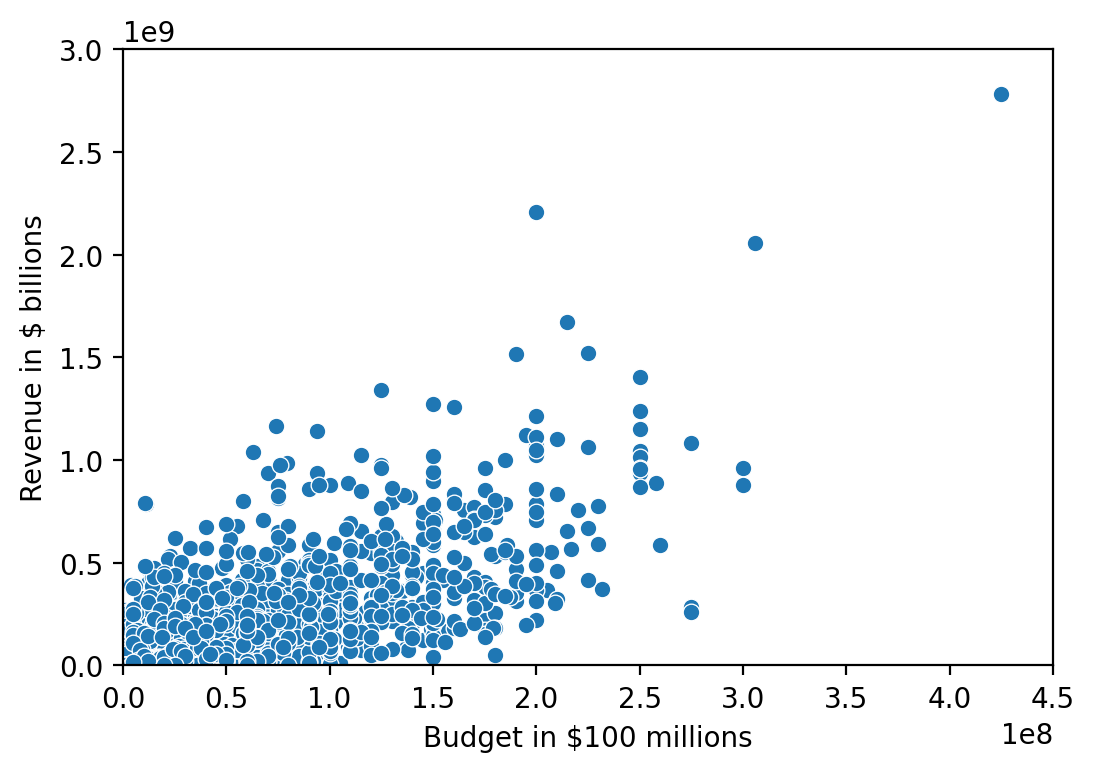

In [71]:
plt.figure(figsize=(6,4), dpi=200)

# creating a scatterplot
ax = sns.scatterplot(
    data = data_clean,
    x='USD_Production_Budget',
    y='USD_Worldwide_Gross',
)

ax.set(
    ylim=(0,3000000000),
    xlim=(0,450000000),
    ylabel='Revenue in $ billions',
    xlabel='Budget in $100 millions',
)

plt.show()

### Plotting Movie Releases over Time

Creating a Bubble Chart:

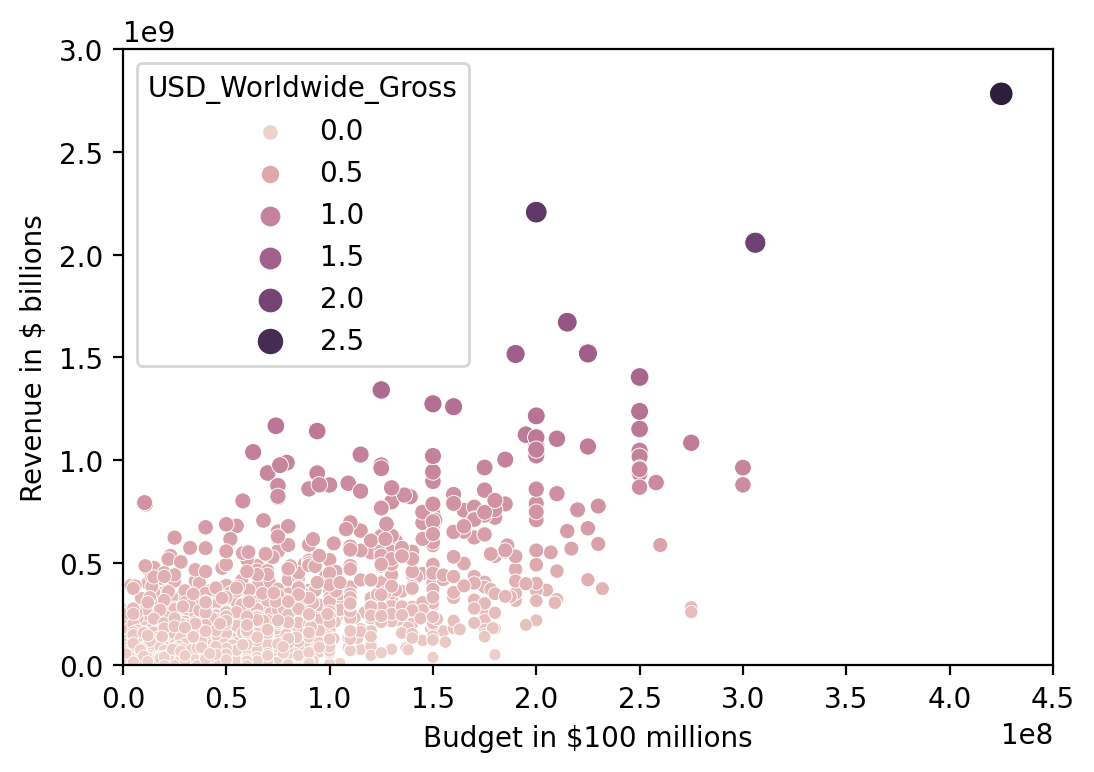

In [73]:
plt.figure(figsize=(6,4), dpi=200)

# bubble chart - some bubbles are bigger and darker (with more revenue)
ax = sns.scatterplot(
    data = data_clean,
    x='USD_Production_Budget',
    y='USD_Worldwide_Gross',
    hue='USD_Worldwide_Gross', # colour
    size='USD_Worldwide_Gross', # dot size
)

ax.set(
    ylim=(0,3000000000),
    xlim=(0,450000000),
    ylabel='Revenue in $ billions',
    xlabel='Budget in $100 millions',
)

plt.show()

Styling the chart

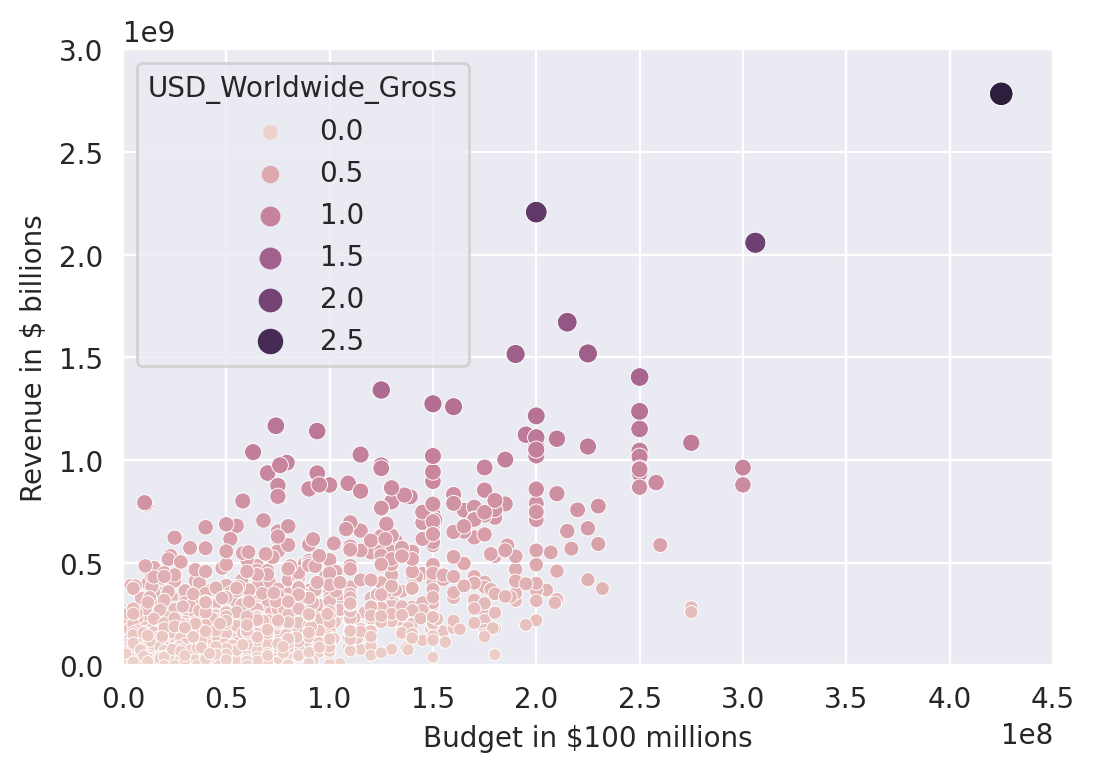

In [79]:
plt.figure(figsize=(6,4), dpi=200)

# set styling on a single chart
# 'whitegrid', 'dark', 'ticks', 'darkgrid'
with sns.axes_style('darkgrid'):
    ax = sns.scatterplot(
        data = data_clean,
        x='USD_Production_Budget',
        y='USD_Worldwide_Gross',
        hue='USD_Worldwide_Gross', # colour
        size='USD_Worldwide_Gross', # dot size
    )

    ax.set(
        ylim=(0,3000000000),
        xlim=(0,450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions',
    )

plt.show()

## Movie Budgets over Time

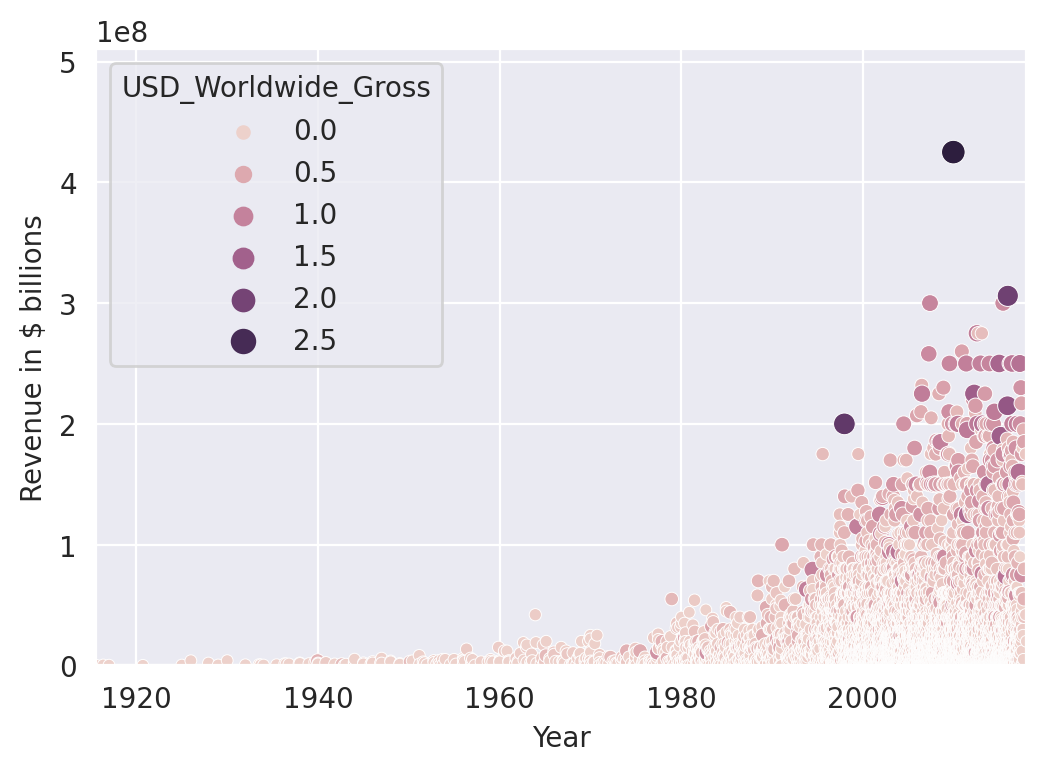

In [86]:
plt.figure(figsize=(6,4), dpi=200)

# set styling on a single chart
# 'whitegrid', 'dark', 'ticks', 'darkgrid'
with sns.axes_style('darkgrid'):
    ax = sns.scatterplot(
        data = data_clean,
        x='Release_Date',
        y='USD_Production_Budget',
        hue='USD_Worldwide_Gross', # colour
        size='USD_Worldwide_Gross', # dot size
    )

    ax.set(
        ylim=(0,data_clean.USD_Production_Budget.max()*1.2),
        xlim=(data_clean.Release_Date.min(),data_clean.Release_Date.max()),
        ylabel='Revenue in $ billions',
        xlabel='Year',
    )

plt.show()

# Converting Years to Decades

Creating a column in `data_clean` that has the decade of the release. 

1. Creating a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grabing all the years from the `DatetimeIndex` object using the `.year` property.
3. Using the floor division `//` to convert the year data to the decades of the films.
4. Adding the decades as a `Decade` column to the `data_clean` DataFrame.

In [90]:
dt_index = pd.DatetimeIndex(data_clean.Release_Date)
years = dt_index.year
decades = (years // 10) *10 
data_clean["Decade"] = decades

### Separating the "old" (before 1969) and "New" (1970s onwards) Films

Creating two new DataFrames: `old_films` and `new_films`
* `old_films` includes all the films before 1969 (up to and including 1969)
* `new_films` includes all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [91]:
old_films = data_clean[data_clean.Decade <= 1960]
new_films = data_clean[data_clean.Decade > 1960]

In [92]:
old_films.describe()

,Rank,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
count,153.00,153.00,153.00,153.00,153.00
mean,"4,274.77","4,611,297.65","30,419,634.38","22,389,473.87","1,949.15"
std,742.14,"5,713,648.85","54,931,828.93","32,641,752.41",12.72
min,"1,253.00","100,000.00",0.00,0.00,"1,910.00"
25%,"3,973.00","1,250,000.00","5,273,000.00","5,000,000.00","1,940.00"
50%,"4,434.00","2,900,000.00","10,000,000.00","10,000,000.00","1,950.00"
75%,"4,785.00","5,000,000.00","33,208,099.00","28,350,000.00","1,960.00"
max,"5,299.00","42,000,000.00","390,525,192.00","198,680,470.00","1,960.00"


In [93]:
old_films.sort_values("USD_Production_Budget", ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
109,1253,1963-12-06,Cleopatra,42000000,71000000,57000000,1960
150,2175,1969-12-16,"Hello, Dolly",24000000,33208099,33208099,1960
143,2465,1969-01-01,Sweet Charity,20000000,8000000,8000000,1960
118,2425,1965-02-15,The Greatest Story Ever Told,20000000,15473333,15473333,1960
148,2375,1969-10-15,Paint Your Wagon,20000000,31678778,31678778,1960


# Seaborn Regression Plots

<AxesSubplot: xlabel='USD_Production_Budget', ylabel='USD_Worldwide_Gross'>

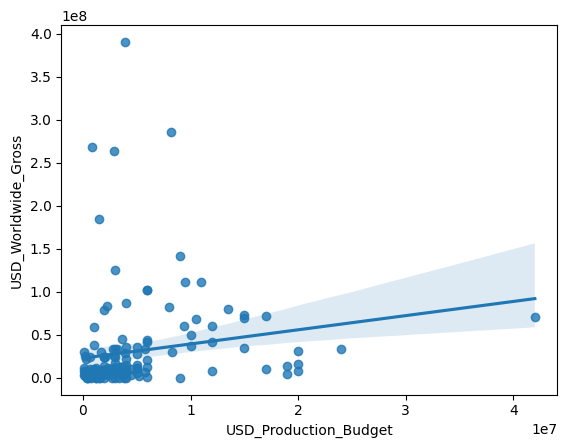

In [97]:
sns.regplot(
    data=old_films,
    x='USD_Production_Budget',
    y='USD_Worldwide_Gross',
)

Using Seaborn's `.regplot()` we can show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>

with the given styling :
* Putting the chart on a `'darkgrid'`.
* Setting limits on the axes so that they don't show negative values.
* Labeling the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Providing HEX colour codes for the plot and the regression line. Making the dots dark blue (#2f4b7c) and the line orange (#ff7c43).


With this chart we will be able to answer following questions.
* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

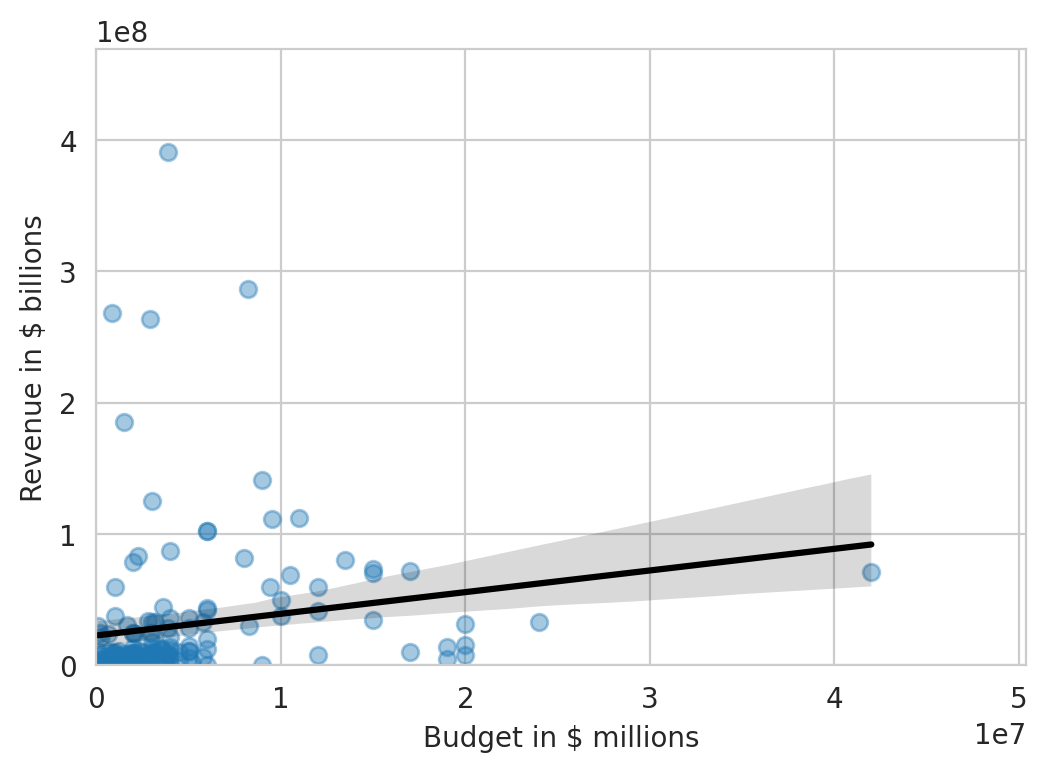

In [103]:
plt.figure(figsize=(6,4), dpi=200)

with sns.axes_style('whitegrid'):
    ax = sns.regplot(
        data = old_films,
        x='USD_Production_Budget',
        y='USD_Worldwide_Gross',
        scatter_kws = {'alpha': 0.4},
        line_kws = {'color': 'black'},
    )

    ax.set(
        ylim=(0,old_films.USD_Worldwide_Gross.max()*1.2),
        xlim=(0,old_films.USD_Production_Budget.max()*1.2),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $ millions',
    )

plt.show()

and for the new movies

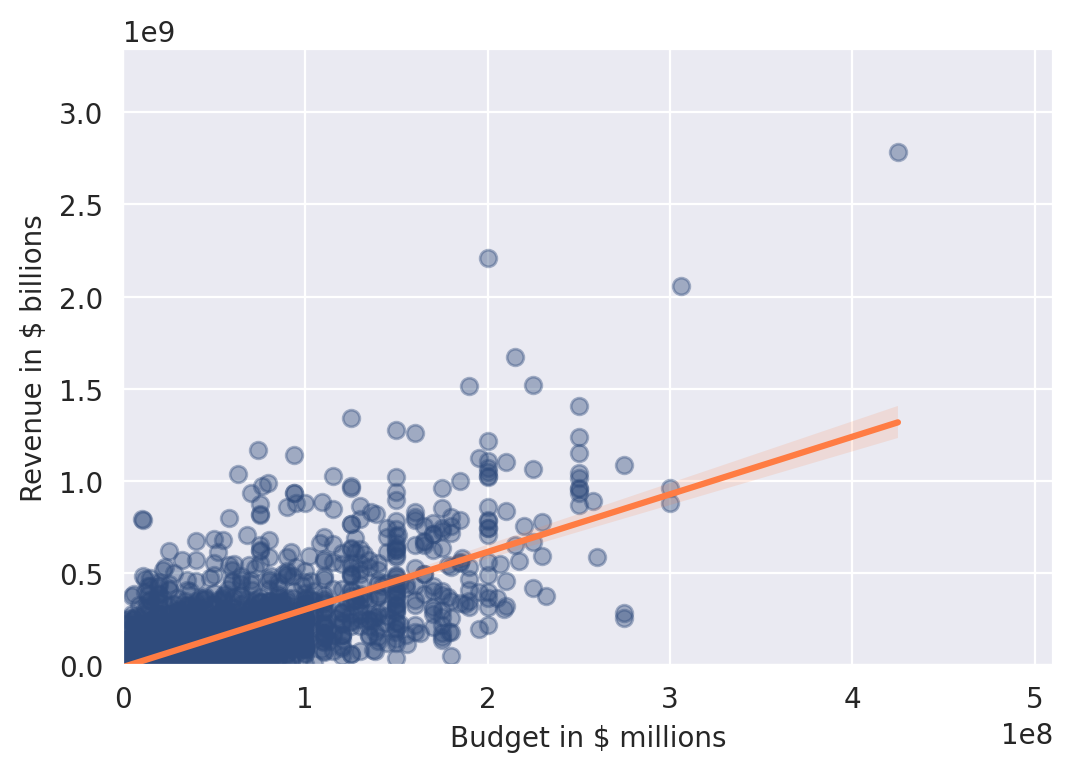

In [105]:
plt.figure(figsize=(6,4), dpi=200)

with sns.axes_style('darkgrid'):
    ax = sns.regplot(
        data = new_films,
        x='USD_Production_Budget',
        y='USD_Worldwide_Gross',
        color='#2f4b7c',
        scatter_kws = {'alpha': 0.4},
        line_kws = {'color': '#ff7c43'},
    )

    ax.set(
        ylim=(0,new_films.USD_Worldwide_Gross.max()*1.2),
        xlim=(0,new_films.USD_Production_Budget.max()*1.2),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $ millions',
    )

plt.show()

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [110]:
regression = LinearRegression()

In [111]:
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])

In [112]:
# Response Variable or Target
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross']) 

In [114]:
regression.fit(X,y)

LinearRegression()

In [115]:
# Theta zero
regression.intercept_

array([-8650768.00661042])

In [116]:
# Theta one
regression.coef_

array([[3.12259592]])

## Interpretation

if a movie budget is $0, the estimated movie revenue is -$8.65.
The slope tells us that for every extra $1 in the budget, movie revenue increases by $3.1

One measure of figuring out how well our model fits our data is by looking at a metric called r-squared. 

In [118]:
# R-squared
regression.score(X, y)
# This means that our model explains about 56% of 
# the variance in movie revenue.

0.5577032617720403

Running a linear regression for the `old_films`. Calculating the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [136]:
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
# Response Variable or Target
y = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross']) 
regression.fit(X,y)
# Theta zero
print(f"The intercept is: {regression.intercept_[0]}")
# Theta one
print(f"The slope coefficient is: {regression.coef_[0][0]}")
# R-squared
# This means that our model explains about 3% of 
# the variance in movie revenue.
print(f"The r-square is: {regression.score(X, y)}")

The intercept is: 22821538.635080386
The slope coefficient is: 1.6477131440107315
The r-square is: 0.02937258620576877


# Using our Model to Make a Prediction

We just estimated the slope and intercept! our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

Based on that we can callculate how much global revenue does our model estimate for a film with a budget of $350 million? 

In [133]:
revenue = regression.intercept_[0] + regression.coef_[0,0] * 350000000

In [134]:
print(f"Estimated Revenue: ${revenue:.10}")

Estimated Revenue: $599521139.0
